## Load in Data

In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import random
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 3
BATCH_SIZE = 256
DOWNLOAD_MNIST = False

m1 = 64
m2 = 128
m3 = 100
cudaopt = True

EPS = 1e-4

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

## Define baseline neural network model

In [16]:
class neural_net(nn.Module):
    def __init__(self,m1,m2,m3):
        super(neural_net, self).__init__()
        
        # Convolutional Filters
        self.W1 = nn.Parameter(torch.randn(m1,1,6,6), requires_grad=True)
        self.strd1 = 2;
        self.W2 = nn.Parameter(torch.randn(m2,m1,6,6), requires_grad=True)
        self.strd2 = 2;
        self.W3 = nn.Parameter(torch.randn(m3,m2,4,4), requires_grad=True)
        self.strd3 = 1;
        
        # Biases / Thresholds
        self.b1 = nn.Parameter(torch.zeros(1,m1,1,1), requires_grad=True)
        self.b2 = nn.Parameter(torch.zeros(1,m2,1,1), requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(1,m3,1,1), requires_grad=True)
        
        # Classifier
        self.Wclass = nn.Linear(m3, 10)
        
        # Initialization
        self.W1.data = 0.01 * self.W1.data
        self.W2.data = 0.01 * self.W2.data
        self.W3.data = 0.01 * self.W3.data
        
    def forward(self, x):    
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2) 
        gamma3 = F.relu(F.conv2d(gamma2,self.W3, stride = self.strd3) + self.b3)                  
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        out = self.Wclass(gamma)
        scores = F.log_softmax(out, dim = 1)    
        return gamma, scores, gamma1.data.cpu().numpy(), gamma2.data.cpu().numpy(), gamma3.data.cpu().numpy()

## Define joint neural network model

In [75]:
class joint_neural_net(nn.Module):
    def __init__(self,m1,m2,m3):
        super(joint_neural_net, self).__init__()
        
        # Convolutional Filters
        self.W1 = nn.Parameter(torch.randn(m1,1,6,6), requires_grad=True)
        self.strd1 = 2;
        self.W2 = nn.Parameter(torch.randn(m2,m1,6,6), requires_grad=True)
        self.strd2 = 2;
        self.W3 = nn.Parameter(torch.randn(m3,m2,4,4), requires_grad=True)
        self.strd3 = 1;
        
        # Biases / Thresholds
        self.b1 = nn.Parameter(torch.zeros(1,m1,1,1), requires_grad=True)
        self.b2 = nn.Parameter(torch.zeros(1,m2,1,1), requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(1,m3,1,1), requires_grad=True)
        
        # Classifier
        self.Wclass = nn.Linear(m3, 10)
        
        # Initialization
        self.W1.data = 0.01 * self.W1.data
        self.W2.data = 0.01 * self.W2.data
        self.W3.data = 0.01 * self.W3.data
        
    def forward(self, x):
        print("Entering normal forward pass of joint network")
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2) 
        gamma3 = F.relu(F.conv2d(gamma2,self.W3, stride = self.strd3)+ self.b3)                  
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        print(gamma3[0])
        print(gamma3[1])
        print(gamma[0])
        print(gamma[1]) 
        out = self.Wclass(gamma)
        scores = F.log_softmax(out, dim = 1)    
        return gamma, scores, gamma1.data.cpu().numpy(), gamma2.data.cpu().numpy(), gamma3.data.cpu().numpy()
    
    def joint_train(self, x, labels):
        # Initialise dics to contain sorted data
        label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]} # Dictionary of lists of tensors
        data_by_class = {} # Dictionary of tensors
        encoded_by_class = {} # Dictionary of tensors
        scores_by_class = {} # Dictionary of lists
        sorted_labels = np.empty(labels.shape[0])
        index = 0
        # Sort data by its label class into a dictionary of lists which contain the data point tensors
        for i in range(labels.shape[0]):
            label_bin_data[str(int(labels[i].item()))].append(x[i,:,:,:])
        # Turn each list of tensors in the dictionary into a tensor
        first = True
        for key, tensor_list in label_bin_data.items():
            if len(label_bin_data[key]) > 0:
                sorted_labels[index:index+len(label_bin_data[key])] = int(key)*np.ones(len(label_bin_data[key]))
                index = index+len(label_bin_data[key])
                data_by_class[key] = torch.stack(label_bin_data[key], dim=0)
                encoded_by_class[key], scores_by_class[key] = self.joint_forward(data_by_class[key])
                if first == True:
                    scores = scores_by_class[key]
                    first = False
                else:
                    scores = torch.cat((scores, scores_by_class[key]), 0)
        return encoded_by_class, scores, torch.from_numpy(sorted_labels).type(torch.cuda.LongTensor)
    

    def joint_forward(self,x):   
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)       # first estimation
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2)
        
        # Encourage joint sparisty in the final layer sparse layer encoding
        X1 = F.conv2d(gamma2, self.W3, stride = self.strd3)
        X1_dims = list(X1.shape)
        X1_mat = X1.view(-1, X1_dims[1])
        st_factors = 1-torch.squeeze(self.b3)*1/(torch.sum(X1_mat**2, dim=0))
        st_factors_mat = torch.diag(st_factors)
        X2_mat = torch.t(torch.mm(st_factors_mat, torch.t(X1_mat)))
        X2 = X2_mat.view(X1_dims[0], X1_dims[1], X1_dims[2], X1_dims[3])    
        gamma3 = F.relu(X2)
            
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        out = self.Wclass(gamma)
        scores = F.log_softmax(out,dim = 1)
        
        return gamma, scores

In [18]:
# W3 = torch.rand(1,1,2,2)
# gamma2 = torch.rand(3,1,4,4)
# # print(gamma2)



# # Encourage joint sparisty in the final layer sparse layer encoding
# X1 = F.conv2d(gamma2, W3, stride = 2)
# print(X1)
# X1_dims = list(X1.shape)
# X1_mat = X1.view(-1, X1_dims[1])
# # print(X1_mat)
# st_factors = 1-1/(torch.sum(X1_mat**2, dim=0))
# st_factors_mat = torch.diag(st_factors)
# X2_mat = X1_mat #torch.t(torch.mm(st_factors_mat, torch.t(X1_mat)))
# X2 = X2_mat.view(X1_dims[0], X1_dims[1], X1_dims[2], X1_dims[3])
# print(X2)
# gamma3 = F.relu(X2)

## Define histogram test function

In [19]:
def test(model, x, labels):
    # Initialise dics to contain sorted data
    label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]} # Dictionary of lists of tensors
    data_by_class = {} # Dictionary of tensors
    encoded_by_class = {} # Dictionary of tensors
    scores_by_class = {} # Dictionary of lists
    sorted_labels = np.empty(labels.shape[0])
    index = 0
    
    activations_count1 = {}
    activations_count2 = {}
    activations_count3 = {}
    
    # Sort data by its label class into a dictionary of lists which contain the data point tensors
    for i in range(labels.shape[0]):
        label_bin_data[str(int(labels[i].item()))].append(x[i,:,:,:])
    # Turn each list of tensors in the dictionary into a tensor
    first = True
    for key, tensor_list in label_bin_data.items():
        if len(label_bin_data[key]) > 0:
            sorted_labels[index:index+len(label_bin_data[key])] = int(key)*np.ones(len(label_bin_data[key]))
            index = index+len(label_bin_data[key])
            data_by_class[key] = torch.stack(label_bin_data[key], dim=0)
            encoded_by_class[key], scores_by_class[key], gamma1, gamma2, gamma3 = model.forward(data_by_class[key])
            activations_count1[key] = count_activations(gamma1, m1)
            activations_count2[key] = count_activations(gamma2, m2)
            activations_count3[key] = count_activations(gamma3, m3)
            if first == True:
                scores = scores_by_class[key]
                first = False
            else:
                scores = torch.cat((scores, scores_by_class[key]), 0)
    sorted_labels = torch.from_numpy(sorted_labels).type(torch.cuda.LongTensor)
    return encoded_by_class, scores, sorted_labels, activations_count1, activations_count2, activations_count3

def count_activations(gamma, numb_nodes, tol=1e-4):
    gamma_dims = list(gamma.shape)
    gamma[gamma<tol]=0
    gamma[gamma>=tol]=1
    activations = np.sum(gamma, axis=3)
    activations = np.sum(activations, axis=2)
    activations = np.sum(activations, axis=0)
    return activations

 ## Train baseline neural network

In [20]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

Loss_test_nn = np.zeros((EPOCH,))
Acc_test_nn = np.zeros((EPOCH,))
Acc_train_nn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Baseline Neural Network Model\n')
    
model = neural_net(m1,m2,m3)

activations_count1_nn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_nn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_nn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}

if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = 1e-7)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
        encoded,scores,_,_,_ = model(b_x)
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients      
    
    Acc_train_nn[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))
    
    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
        encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test(model, b_x, b_y)
        
        for key, tensor_list in activations1.items():
            activations_count1_nn[key] += activations1[key]
            activations_count2_nn[key] += activations2[key]
            activations_count3_nn[key] += activations3[key]
                
        test_loss += F.nll_loss(scores, sorted_labels, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(sorted_labels.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_nn[epoch] = test_loss
    Acc_test_nn[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'cnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Baseline Neural Network Model



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
\ |                    #                            | 100 Elapsed Time: 0:00:17

## Train joint neural network

In [76]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

Loss_test_jnn = np.zeros((EPOCH,))
Acc_test_jnn = np.zeros((EPOCH,))
Acc_train_jnn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint Neural Network Model\n')
    
model_jnn = joint_neural_net(m1,m2,m3)

activations_count1_jnn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_jnn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_jnn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}

if cudaopt:
    model_jnn.cuda()

optimizer_jnn = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = 1e-7)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
        encoded, scores, sorted_labels = model_jnn.joint_train(b_x, b_y)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(sorted_labels.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, sorted_labels)      # negative log likelyhood
        optimizer_jnn.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer_jnn.step()                    # apply gradients
    
    Acc_train_jnn[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))
            
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
        
#         encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test(model_jnn, b_x, b_y)    
        gamma, scores,_,_,_ = model_jnn.forward(b_x)
    
#         for key, tensor_list in activations1.items():
#             activations_count1_jnn[key] += activations1[key]
#             activations_count2_jnn[key] += activations2[key]
#             activations_count3_jnn[key] += activations3[key]

        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0] # change b_y back to sorted_labels
        pred = scores.data.max(1, keepdim=True)[1]
#         print(b_y)
#         print(sorted_labels)
#         print(pred)
#         print(pred.eq(sorted_labels.data.view_as(pred)).long().cpu().sum())
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum() # change b_y back to sorted_labels

    test_loss /= len(test_loader.dataset)
    Loss_test_jnn[epoch] = test_loss
    Acc_test_jnn[epoch] =  100 * float(correct) /float(len(train_loader.dataset))
    
torch.save(model_jnn.state_dict(), 'jcnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint Neural Network Model

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0404]],

        [[ 1.2294]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0408]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3458]],

        [[ 0.0000]],

        [[ 0.0140]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3031]],

        [[ 0.0000]],

        [[ 0.0281]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2807]],

        [[ 0.0000]],

        [[ 1.2528]],

        [[ 1.1361]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2176]],

        [[

/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0393]],

        [[ 1.2331]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0395]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3383]],

        [[ 0.0000]],

        [[ 0.0167]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2974]],

        [[ 0.0000]],

        [[ 0.0259]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2811]],

        [[ 0.0000]],

        [[ 1.2493]],

        [[ 1.1443]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2254]],

        [[ 1.1863]],

        [[ 0.0000]],

        [[ 0.3301]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0404]],

        [[ 1.2375]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0390]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3595]],

        [[ 0.0000]],

        [[ 0.0058]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2900]],

        [[ 0.0000]],

        [[ 0.0268]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2612]],

        [[ 0.0000]],

        [[ 1.2360]],

        [[ 1.1240]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2226]],

        [[ 1.1647]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0601]],

        [[ 1.2291]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0424]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3685]],

        [[ 0.0000]],

        [[ 0.0167]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3120]],

        [[ 0.0000]],

        [[ 0.0316]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2743]],

        [[ 0.0000]],

        [[ 1.2502]],

        [[ 1.1250]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2247]],

        [[ 1.1719]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0513]],

        [[ 1.2363]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0488]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3581]],

        [[ 0.0000]],

        [[ 0.0228]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3070]],

        [[ 0.0000]],

        [[ 0.0275]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2789]],

        [[ 0.0000]],

        [[ 1.2419]],

        [[ 1.1133]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2211]],

        [[ 1.1740]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0480]],

        [[ 1.2408]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0365]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3612]],

        [[ 0.0000]],

        [[ 0.0135]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2983]],

        [[ 0.0000]],

        [[ 0.0217]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2683]],

        [[ 0.0000]],

        [[ 1.2449]],

        [[ 1.1196]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2291]],

        [[ 1.1700]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0519]],

        [[ 1.2372]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0368]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3576]],

        [[ 0.0000]],

        [[ 0.0077]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2977]],

        [[ 0.0000]],

        [[ 0.0307]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2644]],

        [[ 0.0000]],

        [[ 1.2473]],

        [[ 1.1272]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2262]],

        [[ 1.1677]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0516]],

        [[ 1.2424]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0376]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3474]],

        [[ 0.0000]],

        [[ 0.0098]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2924]],

        [[ 0.0000]],

        [[ 0.0318]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2691]],

        [[ 0.0000]],

        [[ 1.2409]],

        [[ 1.1256]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2386]],

        [[ 1.1704]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0480]],

        [[ 1.2317]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0378]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3595]],

        [[ 0.0000]],

        [[ 0.0158]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2997]],

        [[ 0.0000]],

        [[ 0.0233]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2688]],

        [[ 0.0000]],

        [[ 1.2458]],

        [[ 1.1196]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2236]],

        [[ 1.1730]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0535]],

        [[ 1.2491]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0447]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3611]],

        [[ 0.0000]],

        [[ 0.0275]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3201]],

        [[ 0.0000]],

        [[ 0.0271]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2752]],

        [[ 0.0000]],

        [[ 1.2496]],

        [[ 1.1236]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2174]],

        [[ 1.1681]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0391]],

        [[ 1.2400]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0438]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3304]],

        [[ 0.0000]],

        [[ 0.0358]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3156]],

        [[ 0.0000]],

        [[ 0.0425]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2836]],

        [[ 0.0000]],

        [[ 1.2339]],

        [[ 1.1144]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2403]],

        [[ 1.1934]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0559]],

        [[ 1.2388]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0436]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3620]],

        [[ 0.0000]],

        [[ 0.0244]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3180]],

        [[ 0.0000]],

        [[ 0.0232]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2778]],

        [[ 0.0000]],

        [[ 1.2448]],

        [[ 1.1216]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2267]],

        [[ 1.1689]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0498]],

        [[ 1.2390]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0398]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3567]],

        [[ 0.0000]],

        [[ 0.0224]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3073]],

        [[ 0.0000]],

        [[ 0.0173]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2738]],

        [[ 0.0000]],

        [[ 1.2439]],

        [[ 1.1170]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2249]],

        [[ 1.1731]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0431]],

        [[ 1.2325]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0398]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3531]],

        [[ 0.0000]],

        [[ 0.0096]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3128]],

        [[ 0.0000]],

        [[ 0.0259]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2621]],

        [[ 0.0000]],

        [[ 1.2424]],

        [[ 1.1256]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2269]],

        [[ 1.1826]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0513,  1.2454,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0408,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3578,  0.0000,  0.0165,  0.0000,
         0.0000,  0.0000,  1.3020,  0.0000,  0.0196,  0.0000,  0.0000,
         0.0000,  1.2669,  0.0000,  1.2471,  1.1236,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2269,  1.1710,  0.0000,
         0.3300,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0797,  0.0000,  0.0000,  0.0516,  0.0000,
         0.0000,  0.0000,  0.0171,  0.2203,  0.0000,  0.0000,  0.0000,
         1.0754,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3955,  1.1377,  1.0201,  0.0000,  0.0000,  1.2372,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2404,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1926,  0.0000,  0.0000,  0.

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0555,  1.2317,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0413,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3569,  0.0000,  0.0171,  0.0000,
         0.0000,  0.0000,  1.3126,  0.0000,  0.0272,  0.0000,  0.0000,
         0.0000,  1.2775,  0.0000,  1.2529,  1.1235,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2217,  1.1701,  0.0000,
         0.3286,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0774,  0.0000,  0.0000,  0.0517,  0.0000,
         0.0000,  0.0000,  0.0241,  0.2114,  0.0000,  0.0000,  0.0000,
         1.0652,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3838,  1.1337,  1.0209,  0.0000,  0.0000,  1.2398,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2532,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1945,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0532]],

        [[ 1.2411]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0379]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3589]],

        [[ 0.0000]],

        [[ 0.0105]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3007]],

        [[ 0.0000]],

        [[ 0.0297]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2621]],

        [[ 0.0000]],

        [[ 1.2468]],

        [[ 1.1267]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2251]],

        [[ 1.1721]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0551,  1.2357,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0291,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3604,  0.0000,  0.0162,  0.0000,
         0.0000,  0.0000,  1.2965,  0.0000,  0.0213,  0.0000,  0.0000,
         0.0000,  1.2659,  0.0000,  1.2473,  1.1159,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2296,  1.1752,  0.0000,
         0.3347,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0828,  0.0000,  0.0000,  0.0569,  0.0000,
         0.0000,  0.0000,  0.0138,  0.2261,  0.0000,  0.0000,  0.0000,
         1.0783,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4035,  1.1353,  1.0172,  0.0000,  0.0000,  1.2285,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2394,  0.0000,  0.0000,
         0.0000,  0.0000,  0.2013,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0571]],

        [[ 1.2442]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0420]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3595]],

        [[ 0.0000]],

        [[ 0.0150]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3045]],

        [[ 0.0000]],

        [[ 0.0278]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2653]],

        [[ 0.0000]],

        [[ 1.2547]],

        [[ 1.1241]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2219]],

        [[ 1.1707]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0509,  1.2403,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0406,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3505,  0.0000,  0.0192,  0.0000,
         0.0000,  0.0000,  1.2961,  0.0000,  0.0272,  0.0000,  0.0000,
         0.0000,  1.2674,  0.0000,  1.2429,  1.1223,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2224,  1.1660,  0.0000,
         0.3353,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0808,  0.0000,  0.0000,  0.0473,  0.0000,
         0.0000,  0.0000,  0.0173,  0.2220,  0.0000,  0.0000,  0.0000,
         1.0701,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3927,  1.1353,  1.0236,  0.0000,  0.0000,  1.2289,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2443,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1968,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0409]],

        [[ 1.2386]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0351]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3445]],

        [[ 0.0000]],

        [[ 0.0145]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3037]],

        [[ 0.0000]],

        [[ 0.0277]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2742]],

        [[ 0.0000]],

        [[ 1.2435]],

        [[ 1.1190]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2269]],

        [[ 1.1738]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0522,  1.2393,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0400,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3622,  0.0000,  0.0149,  0.0000,
         0.0000,  0.0000,  1.3036,  0.0000,  0.0200,  0.0000,  0.0000,
         0.0000,  1.2700,  0.0000,  1.2456,  1.1247,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2250,  1.1664,  0.0000,
         0.3274,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0782,  0.0000,  0.0000,  0.0521,  0.0000,
         0.0000,  0.0000,  0.0222,  0.2199,  0.0000,  0.0000,  0.0000,
         1.0725,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3980,  1.1376,  1.0224,  0.0000,  0.0000,  1.2380,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2429,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1940,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0489]],

        [[ 1.2421]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0377]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3575]],

        [[ 0.0000]],

        [[ 0.0109]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3010]],

        [[ 0.0000]],

        [[ 0.0287]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2659]],

        [[ 0.0000]],

        [[ 1.2439]],

        [[ 1.1280]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2236]],

        [[ 1.1728]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0414,  1.2370,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0474,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3353,  0.0000,  0.0196,  0.0000,
         0.0000,  0.0000,  1.3034,  0.0000,  0.0336,  0.0000,  0.0000,
         0.0000,  1.2700,  0.0000,  1.2392,  1.1154,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2338,  1.1808,  0.0000,
         0.3351,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0894,  0.0000,  0.0000,  0.0547,  0.0000,
         0.0000,  0.0000,  0.0279,  0.2174,  0.0000,  0.0000,  0.0000,
         1.0791,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4058,  1.1381,  1.0090,  0.0000,  0.0000,  1.2223,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2475,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1977,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0419]],

        [[ 1.2458]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0368]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3529]],

        [[ 0.0000]],

        [[ 0.0140]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2985]],

        [[ 0.0000]],

        [[ 0.0294]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2674]],

        [[ 0.0000]],

        [[ 1.2426]],

        [[ 1.1263]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2295]],

        [[ 1.1706]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0476,  1.2390,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0248,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3580,  0.0000,  0.0227,  0.0000,
         0.0000,  0.0000,  1.3002,  0.0000,  0.0236,  0.0000,  0.0000,
         0.0000,  1.2681,  0.0000,  1.2557,  1.1191,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2379,  1.1680,  0.0000,
         0.3346,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0983,  0.0000,  0.0000,  0.0568,  0.0000,
         0.0000,  0.0000,  0.0039,  0.2159,  0.0000,  0.0000,  0.0000,
         1.0875,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4188,  1.1358,  0.9983,  0.0000,  0.0000,  1.2246,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2419,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1997,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0513]],

        [[ 1.2502]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0479]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3446]],

        [[ 0.0000]],

        [[ 0.0179]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3017]],

        [[ 0.0000]],

        [[ 0.0300]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2657]],

        [[ 0.0000]],

        [[ 1.2431]],

        [[ 1.1290]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2284]],

        [[ 1.1660]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0536,  1.2410,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0382,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3555,  0.0000,  0.0077,  0.0000,
         0.0000,  0.0000,  1.3091,  0.0000,  0.0251,  0.0000,  0.0000,
         0.0000,  1.2684,  0.0000,  1.2417,  1.1240,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2253,  1.1731,  0.0000,
         0.3301,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0758,  0.0000,  0.0000,  0.0511,  0.0000,
         0.0000,  0.0000,  0.0166,  0.2260,  0.0000,  0.0000,  0.0000,
         1.0744,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4001,  1.1337,  1.0217,  0.0000,  0.0000,  1.2338,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2376,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1921,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0462]],

        [[ 1.2363]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0346]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3606]],

        [[ 0.0000]],

        [[ 0.0123]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2981]],

        [[ 0.0000]],

        [[ 0.0258]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2639]],

        [[ 0.0000]],

        [[ 1.2468]],

        [[ 1.1283]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2265]],

        [[ 1.1681]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0477,  1.2364,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0383,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3615,  0.0000,  0.0128,  0.0000,
         0.0000,  0.0000,  1.3004,  0.0000,  0.0263,  0.0000,  0.0000,
         0.0000,  1.2675,  0.0000,  1.2460,  1.1299,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2210,  1.1684,  0.0000,
         0.3373,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0806,  0.0000,  0.0000,  0.0538,  0.0000,
         0.0000,  0.0000,  0.0240,  0.2221,  0.0000,  0.0000,  0.0000,
         1.0724,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.4000,  1.1385,  1.0215,  0.0000,  0.0000,  1.2309,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2415,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1965,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0493]],

        [[ 1.2322]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0396]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3541]],

        [[ 0.0000]],

        [[ 0.0137]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3030]],

        [[ 0.0000]],

        [[ 0.0267]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2723]],

        [[ 0.0000]],

        [[ 1.2390]],

        [[ 1.1207]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2265]],

        [[ 1.1708]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0516]],

        [[ 1.2396]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0429]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3560]],

        [[ 0.0000]],

        [[ 0.0155]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2997]],

        [[ 0.0000]],

        [[ 0.0308]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2701]],

        [[ 0.0000]],

        [[ 1.2478]],

        [[ 1.1261]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2240]],

        [[ 1.1708]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0478]],

        [[ 1.2356]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0362]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3600]],

        [[ 0.0000]],

        [[ 0.0117]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2985]],

        [[ 0.0000]],

        [[ 0.0240]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2648]],

        [[ 0.0000]],

        [[ 1.2450]],

        [[ 1.1270]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2236]],

        [[ 1.1714]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0380,  1.2394,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0532,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3471,  0.0000,  0.0185,  0.0000,
         0.0000,  0.0000,  1.3029,  0.0000,  0.0376,  0.0000,  0.0000,
         0.0000,  1.2771,  0.0000,  1.2354,  1.1091,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2326,  1.1755,  0.0000,
         0.3389,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0896,  0.0000,  0.0000,  0.0529,  0.0000,
         0.0000,  0.0000,  0.0270,  0.2249,  0.0000,  0.0000,  0.0000,
         1.0779,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3970,  1.1333,  1.0147,  0.0000,  0.0000,  1.2273,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2504,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1838,  0.0000,  0.0000,  0.

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0537,  1.2353,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0386,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3584,  0.0000,  0.0177,  0.0000,
         0.0000,  0.0000,  1.3017,  0.0000,  0.0275,  0.0000,  0.0000,
         0.0000,  1.2664,  0.0000,  1.2498,  1.1212,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2288,  1.1707,  0.0000,
         0.3377,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0952,  0.0000,  0.0000,  0.0528,  0.0000,
         0.0000,  0.0000,  0.0119,  0.2189,  0.0000,  0.0000,  0.0000,
         1.0670,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3968,  1.1316,  1.0194,  0.0000,  0.0000,  1.2212,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2413,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1960,  0.0000,  0.0000,  0.

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.0523,  1.2392,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0422,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.3626,  0.0000,  0.0143,  0.0000,
         0.0000,  0.0000,  1.2990,  0.0000,  0.0269,  0.0000,  0.0000,
         0.0000,  1.2734,  0.0000,  1.2443,  1.1292,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2239,  1.1705,  0.0000,
         0.3316,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0760,  0.0000,  0.0000,  0.0565,  0.0000,
         0.0000,  0.0000,  0.0208,  0.2177,  0.0000,  0.0000,  0.0000,
         1.0699,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.3970,  1.1295,  1.0232,  0.0000,  0.0000,  1.2341,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.2436,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1967,  0.0000,  0.0000,  0.

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0443]],

        [[ 1.2367]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0438]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3606]],

        [[ 0.0000]],

        [[ 0.0195]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3056]],

        [[ 0.0000]],

        [[ 0.0211]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2683]],

        [[ 0.0000]],

        [[ 1.2439]],

        [[ 1.1213]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2226]],

        [[ 1.1728]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0486]],

        [[ 1.2355]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0374]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3555]],

        [[ 0.0000]],

        [[ 0.0243]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3043]],

        [[ 0.0000]],

        [[ 0.0235]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2775]],

        [[ 0.0000]],

        [[ 1.2456]],

        [[ 1.1163]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2270]],

        [[ 1.1768]],

        [[ 0.0000]],

        [[ 0.3265]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0475]],

        [[ 1.2323]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0447]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3601]],

        [[ 0.0000]],

        [[ 0.0107]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3060]],

        [[ 0.0000]],

        [[ 0.0287]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2760]],

        [[ 0.0000]],

        [[ 1.2415]],

        [[ 1.1195]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2257]],

        [[ 1.1778]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0480]],

        [[ 1.2429]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0436]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3576]],

        [[ 0.0000]],

        [[ 0.0158]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3032]],

        [[ 0.0000]],

        [[ 0.0274]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2714]],

        [[ 0.0000]],

        [[ 1.2434]],

        [[ 1.1256]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2242]],

        [[ 1.1659]],

        [[ 0.0000]],

        [[ 0.3342]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0533]],

        [[ 1.2357]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0403]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3548]],

        [[ 0.0000]],

        [[ 0.0242]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3028]],

        [[ 0.0000]],

        [[ 0.0216]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2719]],

        [[ 0.0000]],

        [[ 1.2463]],

        [[ 1.1186]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2267]],

        [[ 1.1744]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0540]],

        [[ 1.2374]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0395]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3487]],

        [[ 0.0000]],

        [[ 0.0116]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2974]],

        [[ 0.0000]],

        [[ 0.0455]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2647]],

        [[ 0.0000]],

        [[ 1.2558]],

        [[ 1.1258]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2356]],

        [[ 1.1591]],

        [[ 0.0000]],

        [

- |   #                                              | 66 Elapsed Time: 0:00:20

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0492]],

        [[ 1.2436]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0449]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3468]],

        [[ 0.0000]],

        [[ 0.0120]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3018]],

        [[ 0.0000]],

        [[ 0.0288]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.2654]],

        [[ 0.0000]],

        [[ 1.2414]],

        [[ 1.1307]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.2275]],

        [[ 1.1661]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1445]],

        [[ 1.3162]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0850]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6852]],

        [[ 0.0000]],

        [[ 0.0106]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4703]],

        [[ 0.0000]],

        [[ 0.0655]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3749]],

        [[ 0.0000]],

        [[ 1.3904]],

        [[ 1.2363]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4655]],

        [[ 1.3366]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1510]],

        [[ 1.3220]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0761]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6731]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4638]],

        [[ 0.0000]],

        [[ 0.0780]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3737]],

        [[ 0.0000]],

        [[ 1.3849]],

        [[ 1.2374]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4705]],

        [[ 1.3325]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1372]],

        [[ 1.3277]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0773]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6801]],

        [[ 0.0000]],

        [[ 0.0026]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4738]],

        [[ 0.0000]],

        [[ 0.0747]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3684]],

        [[ 0.0000]],

        [[ 1.3880]],

        [[ 1.2370]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4656]],

        [[ 1.3409]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1491]],

        [[ 1.3190]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0826]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6844]],

        [[ 0.0000]],

        [[ 0.0139]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4770]],

        [[ 0.0000]],

        [[ 0.0624]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3816]],

        [[ 0.0000]],

        [[ 1.3909]],

        [[ 1.2285]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4633]],

        [[ 1.3398]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1393]],

        [[ 1.3115]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0877]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6751]],

        [[ 0.0000]],

        [[ 0.0322]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4821]],

        [[ 0.0000]],

        [[ 0.0737]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3744]],

        [[ 0.0000]],

        [[ 1.3864]],

        [[ 1.2198]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4648]],

        [[ 1.3494]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1433]],

        [[ 1.3264]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0859]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6844]],

        [[ 0.0000]],

        [[ 0.0021]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4726]],

        [[ 0.0000]],

        [[ 0.0711]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3692]],

        [[ 0.0000]],

        [[ 1.3895]],

        [[ 1.2360]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4572]],

        [[ 1.3321]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1404]],

        [[ 1.3180]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0930]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6775]],

        [[ 0.0000]],

        [[ 0.0139]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4800]],

        [[ 0.0000]],

        [[ 0.0709]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3753]],

        [[ 0.0000]],

        [[ 1.3867]],

        [[ 1.2367]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4640]],

        [[ 1.3290]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1371]],

        [[ 1.3228]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0833]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6852]],

        [[ 0.0000]],

        [[ 0.0077]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4698]],

        [[ 0.0000]],

        [[ 0.0659]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3716]],

        [[ 0.0000]],

        [[ 1.3909]],

        [[ 1.2366]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4711]],

        [[ 1.3343]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1400]],

        [[ 1.3164]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0827]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6853]],

        [[ 0.0000]],

        [[ 0.0033]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4735]],

        [[ 0.0000]],

        [[ 0.0697]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3732]],

        [[ 0.0000]],

        [[ 1.3916]],

        [[ 1.2390]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4620]],

        [[ 1.3367]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1444]],

        [[ 1.3122]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0804]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6837]],

        [[ 0.0000]],

        [[ 0.0074]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4695]],

        [[ 0.0000]],

        [[ 0.0674]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3752]],

        [[ 0.0000]],

        [[ 1.3906]],

        [[ 1.2239]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4625]],

        [[ 1.3387]],

        [[ 0.0000]],

        [[ 0.4727]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1495]],

        [[ 1.3153]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0879]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6859]],

        [[ 0.0000]],

        [[ 0.0093]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4717]],

        [[ 0.0000]],

        [[ 0.0764]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3704]],

        [[ 0.0000]],

        [[ 1.3976]],

        [[ 1.2313]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4620]],

        [[ 1.3364]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1389]],

        [[ 1.3137]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0866]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6810]],

        [[ 0.0000]],

        [[ 0.0007]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4694]],

        [[ 0.0000]],

        [[ 0.0660]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3732]],

        [[ 0.0000]],

        [[ 1.3854]],

        [[ 1.2395]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4633]],

        [[ 1.3365]],

        [[ 0.0000]],

        [[ 0.4860]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1341]],

        [[ 1.3183]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0818]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6848]],

        [[ 0.0000]],

        [[ 0.0035]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4696]],

        [[ 0.0000]],

        [[ 0.0766]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3756]],

        [[ 0.0000]],

        [[ 1.3966]],

        [[ 1.2390]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4621]],

        [[ 1.3334]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1436]],

        [[ 1.3395]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0757]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6719]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4698]],

        [[ 0.0000]],

        [[ 0.0843]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3699]],

        [[ 0.0000]],

        [[ 1.3859]],

        [[ 1.2367]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4779]],

        [[ 1.3296]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1378]],

        [[ 1.3261]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0906]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6814]],

        [[ 0.0000]],

        [[ 0.0119]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4816]],

        [[ 0.0000]],

        [[ 0.0618]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3782]],

        [[ 0.0000]],

        [[ 1.3856]],

        [[ 1.2389]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4586]],

        [[ 1.3260]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1459]],

        [[ 1.3184]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0878]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6880]],

        [[ 0.0000]],

        [[ 0.0068]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4821]],

        [[ 0.0000]],

        [[ 0.0712]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3803]],

        [[ 0.0000]],

        [[ 1.3999]],

        [[ 1.2346]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4592]],

        [[ 1.3300]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1208]],

        [[ 1.3066]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0810]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6710]],

        [[ 0.0000]],

        [[ 0.0074]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4704]],

        [[ 0.0000]],

        [[ 0.0924]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3609]],

        [[ 0.0000]],

        [[ 1.4116]],

        [[ 1.2344]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4836]],

        [[ 1.2980]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1402]],

        [[ 1.3129]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0871]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6747]],

        [[ 0.0000]],

        [[ 0.0017]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4650]],

        [[ 0.0000]],

        [[ 0.0860]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3700]],

        [[ 0.0000]],

        [[ 1.3926]],

        [[ 1.2385]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4650]],

        [[ 1.3320]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1388]],

        [[ 1.3128]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0814]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6848]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4709]],

        [[ 0.0000]],

        [[ 0.0886]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3716]],

        [[ 0.0000]],

        [[ 1.4060]],

        [[ 1.2386]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4680]],

        [[ 1.3163]],

        [[ 0.0000]],

        [[ 0.4859]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1408]],

        [[ 1.3066]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0899]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6706]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4701]],

        [[ 0.0000]],

        [[ 0.0780]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3600]],

        [[ 0.0000]],

        [[ 1.3960]],

        [[ 1.2377]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4660]],

        [[ 1.3296]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1408]],

        [[ 1.3111]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0859]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6739]],

        [[ 0.0000]],

        [[ 0.0006]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4746]],

        [[ 0.0000]],

        [[ 0.0728]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3839]],

        [[ 0.0000]],

        [[ 1.3899]],

        [[ 1.2376]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4618]],

        [[ 1.3368]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1497]],

        [[ 1.3097]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0920]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6700]],

        [[ 0.0000]],

        [[ 0.0225]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4721]],

        [[ 0.0000]],

        [[ 0.0752]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3756]],

        [[ 0.0000]],

        [[ 1.3823]],

        [[ 1.2380]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4656]],

        [[ 1.3470]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1433]],

        [[ 1.3163]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0921]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6698]],

        [[ 0.0000]],

        [[ 0.0082]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4621]],

        [[ 0.0000]],

        [[ 0.0822]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3698]],

        [[ 0.0000]],

        [[ 1.3891]],

        [[ 1.2313]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4674]],

        [[ 1.3296]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1381]],

        [[ 1.3150]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0888]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6776]],

        [[ 0.0000]],

        [[ 0.0067]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4746]],

        [[ 0.0000]],

        [[ 0.0696]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3758]],

        [[ 0.0000]],

        [[ 1.3882]],

        [[ 1.2341]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4646]],

        [[ 1.3339]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1393]],

        [[ 1.3210]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0908]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6843]],

        [[ 0.0000]],

        [[ 0.0235]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4682]],

        [[ 0.0000]],

        [[ 0.0661]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3771]],

        [[ 0.0000]],

        [[ 1.3945]],

        [[ 1.2423]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4576]],

        [[ 1.3299]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1388]],

        [[ 1.3161]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0899]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6781]],

        [[ 0.0000]],

        [[ 0.0196]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4764]],

        [[ 0.0000]],

        [[ 0.0695]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3796]],

        [[ 0.0000]],

        [[ 1.3894]],

        [[ 1.2275]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4632]],

        [[ 1.3390]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1298]],

        [[ 1.3114]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0899]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6784]],

        [[ 0.0000]],

        [[ 0.0312]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4747]],

        [[ 0.0000]],

        [[ 0.0806]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3792]],

        [[ 0.0000]],

        [[ 1.3873]],

        [[ 1.2284]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4728]],

        [[ 1.3508]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1329]],

        [[ 1.3106]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0810]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6813]],

        [[ 0.0000]],

        [[ 0.0031]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4743]],

        [[ 0.0000]],

        [[ 0.0856]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3813]],

        [[ 0.0000]],

        [[ 1.3959]],

        [[ 1.2460]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4620]],

        [[ 1.3420]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1415]],

        [[ 1.3137]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0805]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6845]],

        [[ 0.0000]],

        [[ 0.0052]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4729]],

        [[ 0.0000]],

        [[ 0.0657]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3757]],

        [[ 0.0000]],

        [[ 1.3862]],

        [[ 1.2351]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4608]],

        [[ 1.3318]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1481]],

        [[ 1.3343]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0717]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6777]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4660]],

        [[ 0.0000]],

        [[ 0.0807]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3702]],

        [[ 0.0000]],

        [[ 1.3834]],

        [[ 1.2363]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4659]],

        [[ 1.3277]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1422]],

        [[ 1.3163]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0839]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6801]],

        [[ 0.0000]],

        [[ 0.0126]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4800]],

        [[ 0.0000]],

        [[ 0.0696]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3686]],

        [[ 0.0000]],

        [[ 1.3965]],

        [[ 1.2323]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4677]],

        [[ 1.3314]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1414]],

        [[ 1.3219]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0750]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6906]],

        [[ 0.0000]],

        [[ 0.0137]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4677]],

        [[ 0.0000]],

        [[ 0.0691]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3755]],

        [[ 0.0000]],

        [[ 1.4044]],

        [[ 1.2235]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4680]],

        [[ 1.3306]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1377]],

        [[ 1.3180]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0948]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6778]],

        [[ 0.0000]],

        [[ 0.0179]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4709]],

        [[ 0.0000]],

        [[ 0.0937]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3882]],

        [[ 0.0000]],

        [[ 1.4075]],

        [[ 1.2375]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4637]],

        [[ 1.3171]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1333]],

        [[ 1.3227]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0866]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6744]],

        [[ 0.0000]],

        [[ 0.0106]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4770]],

        [[ 0.0000]],

        [[ 0.0651]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3760]],

        [[ 0.0000]],

        [[ 1.3855]],

        [[ 1.2361]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4622]],

        [[ 1.3295]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1439]],

        [[ 1.3257]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0811]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6892]],

        [[ 0.0000]],

        [[ 0.0082]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4696]],

        [[ 0.0000]],

        [[ 0.0638]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3708]],

        [[ 0.0000]],

        [[ 1.3903]],

        [[ 1.2465]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4787]],

        [[ 1.3371]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1413]],

        [[ 1.3230]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0879]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6813]],

        [[ 0.0000]],

        [[ 0.0073]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4825]],

        [[ 0.0000]],

        [[ 0.0637]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3786]],

        [[ 0.0000]],

        [[ 1.3890]],

        [[ 1.2308]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4653]],

        [[ 1.3309]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1437]],

        [[ 1.3184]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0845]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6855]],

        [[ 0.0000]],

        [[ 0.0051]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4760]],

        [[ 0.0000]],

        [[ 0.0708]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3754]],

        [[ 0.0000]],

        [[ 1.3893]],

        [[ 1.2372]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4599]],

        [[ 1.3302]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1465]],

        [[ 1.3142]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0876]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6866]],

        [[ 0.0000]],

        [[ 0.0006]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4733]],

        [[ 0.0000]],

        [[ 0.0807]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3738]],

        [[ 0.0000]],

        [[ 1.3917]],

        [[ 1.2333]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4635]],

        [[ 1.3328]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1423]],

        [[ 1.3180]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0774]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6848]],

        [[ 0.0000]],

        [[ 0.0028]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4759]],

        [[ 0.0000]],

        [[ 0.0685]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3712]],

        [[ 0.0000]],

        [[ 1.3874]],

        [[ 1.2340]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4668]],

        [[ 1.3327]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1462]],

        [[ 1.3184]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0814]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6864]],

        [[ 0.0000]],

        [[ 0.0065]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4816]],

        [[ 0.0000]],

        [[ 0.0666]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3726]],

        [[ 0.0000]],

        [[ 1.3849]],

        [[ 1.2398]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4749]],

        [[ 1.3358]],

        [[ 0.0000]],

        [[ 0.4800]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1388]],

        [[ 1.3173]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0802]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6809]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4699]],

        [[ 0.0000]],

        [[ 0.0757]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3741]],

        [[ 0.0000]],

        [[ 1.3880]],

        [[ 1.2331]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4631]],

        [[ 1.3339]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1568]],

        [[ 1.3283]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0866]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6885]],

        [[ 0.0000]],

        [[ 0.0010]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4904]],

        [[ 0.0000]],

        [[ 0.0707]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3903]],

        [[ 0.0000]],

        [[ 1.4008]],

        [[ 1.2392]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4619]],

        [[ 1.3277]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1420]],

        [[ 1.3086]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0794]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6721]],

        [[ 0.0000]],

        [[ 0.0294]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4810]],

        [[ 0.0000]],

        [[ 0.0712]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3734]],

        [[ 0.0000]],

        [[ 1.3888]],

        [[ 1.2302]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4712]],

        [[ 1.3498]],

        [[ 0.0000]],

        [

\ |                #                                | 100 Elapsed Time: 0:00:40

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1430]],

        [[ 1.3187]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0782]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.6756]],

        [[ 0.0000]],

        [[ 0.0093]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4741]],

        [[ 0.0000]],

        [[ 0.0730]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3759]],

        [[ 0.0000]],

        [[ 1.3828]],

        [[ 1.2363]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4620]],

        [[ 1.3351]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1898]],

        [[ 1.3503]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1874]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7021]],

        [[ 0.0000]],

        [[ 0.0066]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4864]],

        [[ 0.0000]],

        [[ 0.1070]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3999]],

        [[ 0.0000]],

        [[ 1.4289]],

        [[ 1.2872]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5020]],

        [[ 1.3460]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1795]],

        [[ 1.3490]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1831]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7192]],

        [[ 0.0000]],

        [[ 0.0097]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4932]],

        [[ 0.0000]],

        [[ 0.0989]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3957]],

        [[ 0.0000]],

        [[ 1.4400]],

        [[ 1.2862]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5114]],

        [[ 1.3481]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1827]],

        [[ 1.3536]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1894]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7068]],

        [[ 0.0000]],

        [[ 0.0139]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5036]],

        [[ 0.0000]],

        [[ 0.0775]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4070]],

        [[ 0.0000]],

        [[ 1.4250]],

        [[ 1.2913]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4923]],

        [[ 1.3476]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1829]],

        [[ 1.3430]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1772]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7175]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4955]],

        [[ 0.0000]],

        [[ 0.0891]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4007]],

        [[ 0.0000]],

        [[ 1.4276]],

        [[ 1.2877]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4993]],

        [[ 1.3491]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1902]],

        [[ 1.3519]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1784]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7170]],

        [[ 0.0000]],

        [[ 0.0025]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4910]],

        [[ 0.0000]],

        [[ 0.0933]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3976]],

        [[ 0.0000]],

        [[ 1.4231]],

        [[ 1.2890]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5043]],

        [[ 1.3555]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1939]],

        [[ 1.3398]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1827]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7188]],

        [[ 0.0000]],

        [[ 0.0160]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4958]],

        [[ 0.0000]],

        [[ 0.0835]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4010]],

        [[ 0.0000]],

        [[ 1.4299]],

        [[ 1.2878]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4964]],

        [[ 1.3598]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1790]],

        [[ 1.3366]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1855]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7018]],

        [[ 0.0000]],

        [[ 0.0004]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4943]],

        [[ 0.0000]],

        [[ 0.0927]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4221]],

        [[ 0.0000]],

        [[ 1.4330]],

        [[ 1.2935]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4906]],

        [[ 1.3686]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1862]],

        [[ 1.3384]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1828]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7045]],

        [[ 0.0000]],

        [[ 0.0067]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5045]],

        [[ 0.0000]],

        [[ 0.0885]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4109]],

        [[ 0.0000]],

        [[ 1.4197]],

        [[ 1.2767]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5015]],

        [[ 1.3564]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1901]],

        [[ 1.3568]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1805]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7230]],

        [[ 0.0000]],

        [[ 0.0231]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4960]],

        [[ 0.0000]],

        [[ 0.0789]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4098]],

        [[ 0.0000]],

        [[ 1.4314]],

        [[ 1.2925]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4916]],

        [[ 1.3456]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1894]],

        [[ 1.3476]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1805]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7206]],

        [[ 0.0000]],

        [[ 0.0036]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4991]],

        [[ 0.0000]],

        [[ 0.0841]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4039]],

        [[ 0.0000]],

        [[ 1.4253]],

        [[ 1.2878]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4939]],

        [[ 1.3515]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1775]],

        [[ 1.3593]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1769]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7217]],

        [[ 0.0000]],

        [[ 0.0050]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4976]],

        [[ 0.0000]],

        [[ 0.0875]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4053]],

        [[ 0.0000]],

        [[ 1.4324]],

        [[ 1.2828]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5021]],

        [[ 1.3506]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1898]],

        [[ 1.3592]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1705]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7084]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5169]],

        [[ 0.0000]],

        [[ 0.0938]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4017]],

        [[ 0.0000]],

        [[ 1.4181]],

        [[ 1.2931]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5057]],

        [[ 1.3707]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1882]],

        [[ 1.3448]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1798]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7156]],

        [[ 0.0000]],

        [[ 0.0111]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4926]],

        [[ 0.0000]],

        [[ 0.0821]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3994]],

        [[ 0.0000]],

        [[ 1.4249]],

        [[ 1.2858]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4972]],

        [[ 1.3587]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1882]],

        [[ 1.3516]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1737]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7152]],

        [[ 0.0000]],

        [[ 0.0044]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4978]],

        [[ 0.0000]],

        [[ 0.0895]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4003]],

        [[ 0.0000]],

        [[ 1.4249]],

        [[ 1.2888]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5031]],

        [[ 1.3534]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1857]],

        [[ 1.3510]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1971]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7037]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4953]],

        [[ 0.0000]],

        [[ 0.0974]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4009]],

        [[ 0.0000]],

        [[ 1.4215]],

        [[ 1.2898]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5125]],

        [[ 1.3484]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1868]],

        [[ 1.3460]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1790]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7160]],

        [[ 0.0000]],

        [[ 0.0053]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4922]],

        [[ 0.0000]],

        [[ 0.0860]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4031]],

        [[ 0.0000]],

        [[ 1.4248]],

        [[ 1.2881]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4992]],

        [[ 1.3525]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1933]],

        [[ 1.3487]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1851]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7226]],

        [[ 0.0000]],

        [[ 0.0166]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4922]],

        [[ 0.0000]],

        [[ 0.0823]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3990]],

        [[ 0.0000]],

        [[ 1.4269]],

        [[ 1.2857]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4947]],

        [[ 1.3449]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1863]],

        [[ 1.3408]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1785]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7105]],

        [[ 0.0000]],

        [[ 0.0124]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4927]],

        [[ 0.0000]],

        [[ 0.0891]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3999]],

        [[ 0.0000]],

        [[ 1.4229]],

        [[ 1.2824]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4986]],

        [[ 1.3607]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1888]],

        [[ 1.3429]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1811]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7141]],

        [[ 0.0000]],

        [[ 0.0038]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5004]],

        [[ 0.0000]],

        [[ 0.0872]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3977]],

        [[ 0.0000]],

        [[ 1.4327]],

        [[ 1.2838]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5041]],

        [[ 1.3467]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1886]],

        [[ 1.3435]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1766]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7100]],

        [[ 0.0000]],

        [[ 0.0055]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4959]],

        [[ 0.0000]],

        [[ 0.1016]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4041]],

        [[ 0.0000]],

        [[ 1.4191]],

        [[ 1.2913]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4965]],

        [[ 1.3506]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1856]],

        [[ 1.3521]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1786]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7197]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4970]],

        [[ 0.0000]],

        [[ 0.0895]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4008]],

        [[ 0.0000]],

        [[ 1.4233]],

        [[ 1.2901]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4954]],

        [[ 1.3582]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1938]],

        [[ 1.3521]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1846]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7223]],

        [[ 0.0000]],

        [[ 0.0145]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5020]],

        [[ 0.0000]],

        [[ 0.0825]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4096]],

        [[ 0.0000]],

        [[ 1.4306]],

        [[ 1.2726]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4969]],

        [[ 1.3447]],

        [[ 0.0000]],

        [[ 0.5132]],

        [[ 0.0000]],

        [[ 

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1905]],

        [[ 1.3456]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1869]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7187]],

        [[ 0.0000]],

        [[ 0.0151]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5019]],

        [[ 0.0000]],

        [[ 0.0732]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4101]],

        [[ 0.0000]],

        [[ 1.4261]],

        [[ 1.2759]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4920]],

        [[ 1.3593]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1932]],

        [[ 1.3380]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1860]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7204]],

        [[ 0.0000]],

        [[ 0.0167]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5002]],

        [[ 0.0000]],

        [[ 0.0761]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4096]],

        [[ 0.0000]],

        [[ 1.4275]],

        [[ 1.2753]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4959]],

        [[ 1.3590]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1874]],

        [[ 1.3403]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1805]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7200]],

        [[ 0.0000]],

        [[ 0.0044]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4985]],

        [[ 0.0000]],

        [[ 0.0880]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3997]],

        [[ 0.0000]],

        [[ 1.4262]],

        [[ 1.2881]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4976]],

        [[ 1.3548]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1818]],

        [[ 1.3400]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1883]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7218]],

        [[ 0.0000]],

        [[ 0.0050]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5001]],

        [[ 0.0000]],

        [[ 0.0915]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4006]],

        [[ 0.0000]],

        [[ 1.4227]],

        [[ 1.2923]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4943]],

        [[ 1.3461]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1941]],

        [[ 1.3491]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1828]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7231]],

        [[ 0.0000]],

        [[ 0.0107]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4996]],

        [[ 0.0000]],

        [[ 0.0800]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4042]],

        [[ 0.0000]],

        [[ 1.4264]],

        [[ 1.2888]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4926]],

        [[ 1.3513]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1917]],

        [[ 1.3475]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1760]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7164]],

        [[ 0.0000]],

        [[ 0.0025]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4988]],

        [[ 0.0000]],

        [[ 0.0821]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4032]],

        [[ 0.0000]],

        [[ 1.4232]],

        [[ 1.2917]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4976]],

        [[ 1.3566]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1980]],

        [[ 1.3439]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1869]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7242]],

        [[ 0.0000]],

        [[ 0.0086]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5056]],

        [[ 0.0000]],

        [[ 0.0866]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4117]],

        [[ 0.0000]],

        [[ 1.4298]],

        [[ 1.2904]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4956]],

        [[ 1.3525]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1843]],

        [[ 1.3519]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1864]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7076]],

        [[ 0.0000]],

        [[ 0.0119]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5027]],

        [[ 0.0000]],

        [[ 0.0798]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4051]],

        [[ 0.0000]],

        [[ 1.4235]],

        [[ 1.2924]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4952]],

        [[ 1.3522]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1820]],

        [[ 1.3400]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1835]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7163]],

        [[ 0.0000]],

        [[ 0.0011]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4911]],

        [[ 0.0000]],

        [[ 0.0880]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4035]],

        [[ 0.0000]],

        [[ 1.4343]],

        [[ 1.2986]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4949]],

        [[ 1.3608]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1839]],

        [[ 1.3512]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1776]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7200]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4934]],

        [[ 0.0000]],

        [[ 0.0863]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.3961]],

        [[ 0.0000]],

        [[ 1.4279]],

        [[ 1.2937]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5040]],

        [[ 1.3612]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1841]],

        [[ 1.3435]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1809]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7161]],

        [[ 0.0000]],

        [[ 0.0091]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4963]],

        [[ 0.0000]],

        [[ 0.0857]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4099]],

        [[ 0.0000]],

        [[ 1.4260]],

        [[ 1.2866]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4949]],

        [[ 1.3584]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1922]],

        [[ 1.3474]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1786]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7158]],

        [[ 0.0000]],

        [[ 0.0144]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5028]],

        [[ 0.0000]],

        [[ 0.0883]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4092]],

        [[ 0.0000]],

        [[ 1.4279]],

        [[ 1.2749]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4981]],

        [[ 1.3615]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1872]],

        [[ 1.3489]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1807]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7247]],

        [[ 0.0000]],

        [[ 0.0074]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4934]],

        [[ 0.0000]],

        [[ 0.0715]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4063]],

        [[ 0.0000]],

        [[ 1.4322]],

        [[ 1.2970]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4945]],

        [[ 1.3527]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1871]],

        [[ 1.3382]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1796]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7122]],

        [[ 0.0000]],

        [[ 0.0265]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5012]],

        [[ 0.0000]],

        [[ 0.0865]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4073]],

        [[ 0.0000]],

        [[ 1.4242]],

        [[ 1.2687]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4965]],

        [[ 1.3666]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1867]],

        [[ 1.3444]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1825]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7193]],

        [[ 0.0000]],

        [[ 0.0041]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4948]],

        [[ 0.0000]],

        [[ 0.0802]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4041]],

        [[ 0.0000]],

        [[ 1.4267]],

        [[ 1.2896]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.4954]],

        [[ 1.3587]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1893]],

        [[ 1.3484]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1761]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7205]],

        [[ 0.0000]],

        [[ 0.0028]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4930]],

        [[ 0.0000]],

        [[ 0.0779]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4007]],

        [[ 0.0000]],

        [[ 1.4275]],

        [[ 1.2815]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5015]],

        [[ 1.3519]],

        [[ 0.0000]],

        [

Entering normal forward pass of joint network
tensor(1.00000e-02 *
       [[[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1839]],

        [[ 1.3642]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1746]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.7126]],

        [[ 0.0000]],

        [[ 0.0051]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.5005]],

        [[ 0.0000]],

        [[ 0.0892]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 1.4020]],

        [[ 0.0000]],

        [[ 1.4199]],

        [[ 1.2886]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.5070]],

        [[ 1.3614]],

        [[ 0.0000]],

        [

tensor(1.00000e-02 *
       [ 0.0000,  0.0000,  0.0000,  0.1903,  1.3529,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.1753,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.7124,  0.0000,  0.0032,  0.0000,
         0.0000,  0.0000,  1.4999,  0.0000,  0.0842,  0.0000,  0.0000,
         0.0000,  1.4070,  0.0000,  1.4261,  1.2869,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.5014,  1.3519,  0.0000,
         0.5348,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.3325,  0.0000,  0.0000,  0.1823,  0.0000,
         0.0000,  0.0000,  0.1815,  0.5344,  0.0000,  0.0000,  0.0000,
         1.1788,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.6425,  1.2848,  1.3105,  0.0000,  0.0000,  1.3304,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.4756,  0.0000,  0.0000,
         0.0000,  0.0000,  0.4722,  0.0000,  0.0000,  0.

## Plot train error

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


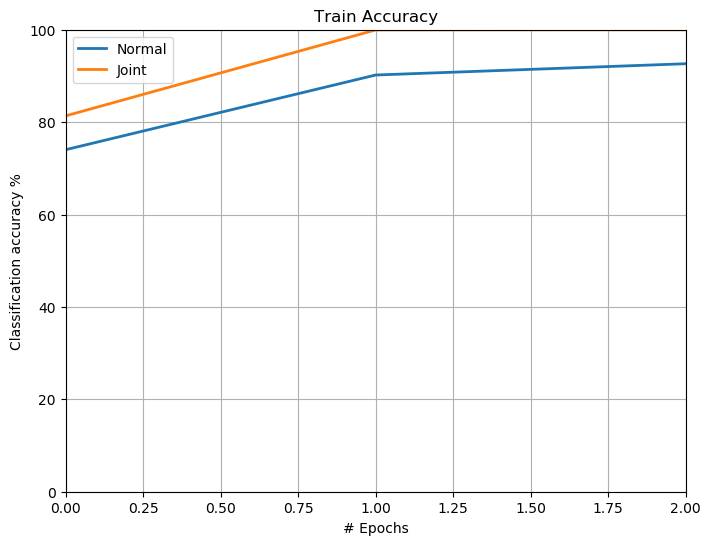

In [65]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_train_nn, linewidth = 2,label='Normal')
plt.plot(Acc_train_jnn, linewidth = 2,label = 'Joint')
plt.grid('on')
plt.title('Train Accuracy')

plt.ylabel('Classification accuracy %')
plt.xlabel('# Epochs')
plt.legend()
plt.axis([0, EPOCH-1, 0, 100])
plt.show()

## Plot test error

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


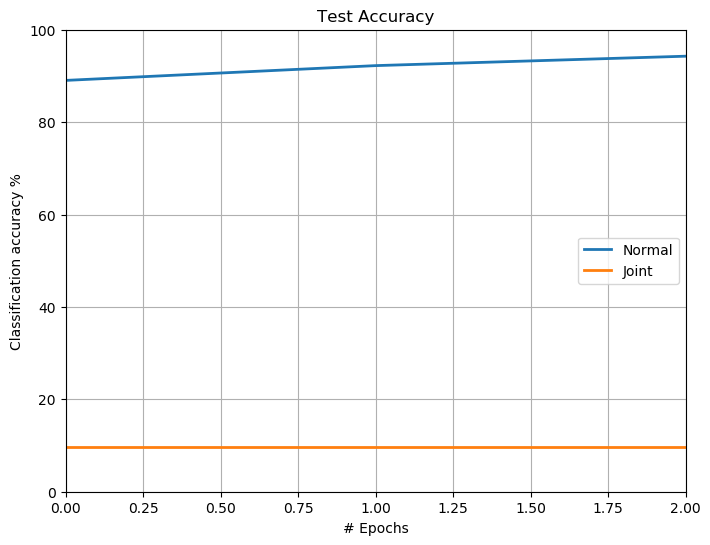

In [72]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_test_nn, linewidth = 2,label='Normal')
plt.plot(Acc_test_jnn, linewidth = 2,label = 'Joint')
plt.grid('on')
plt.title('Test Accuracy')

plt.ylabel('Classification accuracy %')
plt.xlabel('# Epochs')
plt.legend()
plt.axis([0, EPOCH-1, 0, 100])
plt.show()

## Plot histogram visualisations

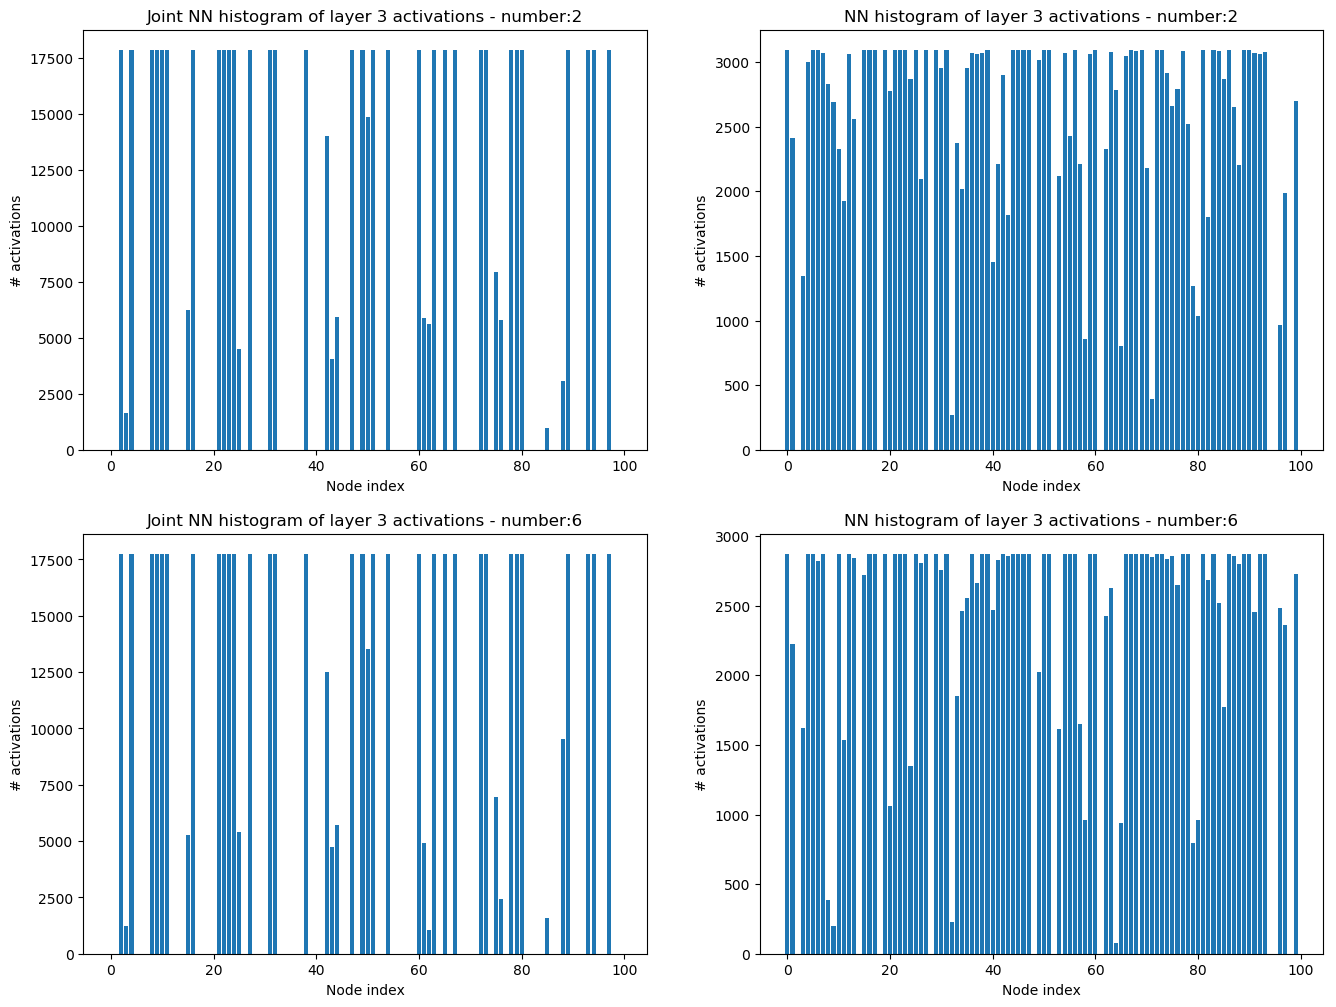

In [47]:
idx1 = 2
idx2 = 6

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.bar(np.arange(m3), activations_count3_jnn[str(idx1)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,2)
plt.bar(np.arange(m3), activations_count3_nn[str(idx1)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,3)
plt.bar(np.arange(m3), activations_count3_jnn[str(idx2)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,4)
plt.bar(np.arange(m3), activations_count3_nn[str(idx2)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.show()

## Visualise global filters leart by baseline network

torch.Size([100, 128, 4, 4])
torch.Size([100, 64, 12, 12])
torch.Size([100, 1, 28, 28])


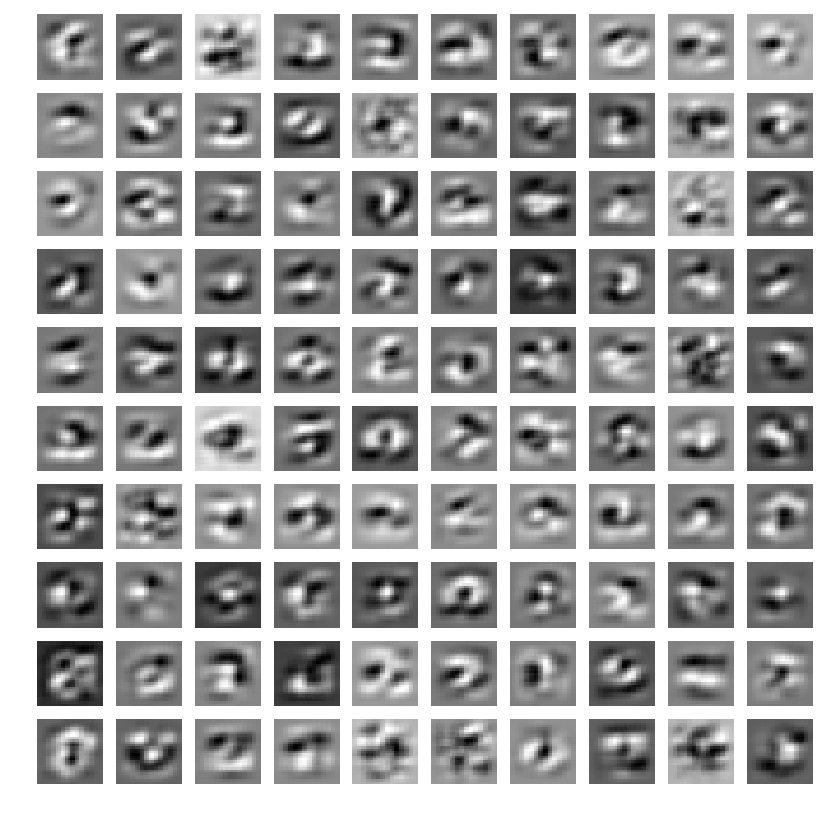

In [48]:
cols = 10
rows = 10
indices = random.sample(range(m3), cols*rows)

dict1 = model.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model.W2, stride=model.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3 = F.conv_transpose2d(dict2, model.W1, stride=model.strd2, dilation=1)
atom3_dim = dict3.shape[3]
print(dict3.shape)

idx = 1
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()

## Visualising global filters learned by Joint Network

torch.Size([100, 128, 4, 4])
torch.Size([100, 64, 12, 12])
torch.Size([100, 1, 28, 28])


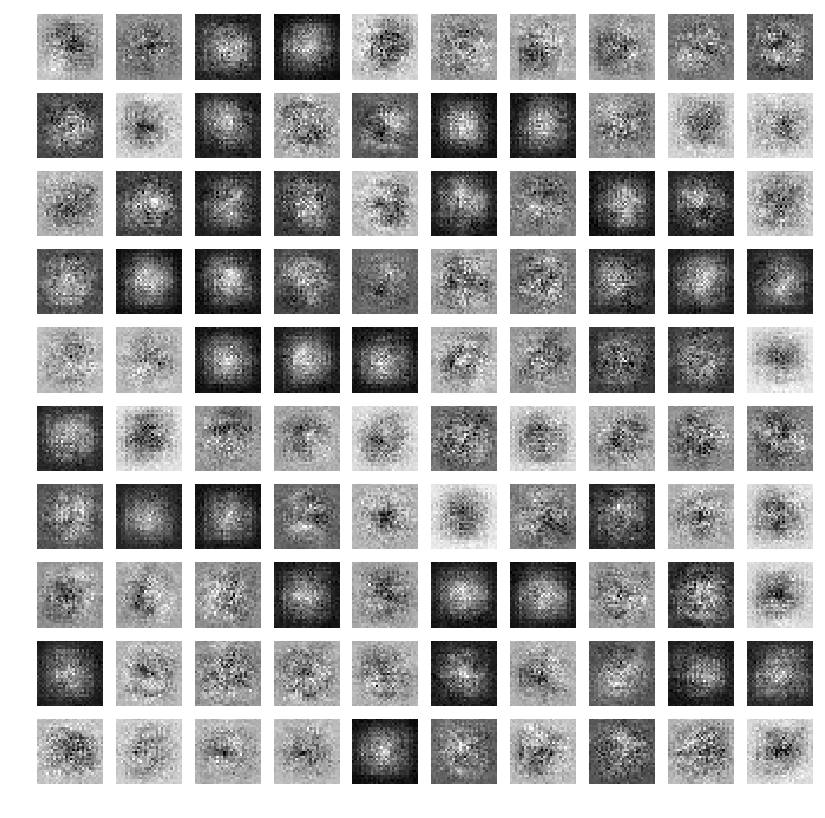

In [49]:
cols = 10
rows = 10
indices = random.sample(range(m3), cols*rows)

dict1 = model_jnn.W3
atom1_dim = dict1.shape[3]
print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_jnn.W2, stride=model.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3 = F.conv_transpose2d(dict2, model_jnn.W1, stride=model.strd2, dilation=1)
atom3_dim = dict3.shape[3]
print(dict3.shape)

idx = 1
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()